In [16]:
%load_ext dotenv
%dotenv -o

import os
os.environ["POLYGON_DATA_DIR"]

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


'/media/mirror/files.polygon.io'

In [17]:
from zipline_polygon_bundle import get_ticker_universe
from zipline_polygon_bundle.config import PolygonConfig

# from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
# from zipline_polygon_bundle import get_custom_aggs_dates

from typing import Iterator, Tuple

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import compute as pc
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [18]:
os.environ["CUSTOM_ASSET_FILES_DIR"]

'/home/jovyan/work/data'

In [19]:
if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/work/data"

if not "POLYGON_TICKERS_DIR" in os.environ:
    os.environ["POLYGON_TICKERS_DIR"]= "/home/jovyan/work/data/tickers"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2018-01-01",
    end_date="2023-12-31",
    agg_time="1min",
)

pd.set_option('display.width', 250)

# print(f"{config.minute_aggs_dir=}")
# print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
# print(f"{config.aggs_dir=}")
# print(f"{config.by_ticker_dir=}")
print(f"{config.tickers_csv_path=}")

config.custom_aggs_dir='/home/jovyan/work/data/60sec_aggs'
config.tickers_csv_path='/home/jovyan/work/data/tickers/tickers_2018-01-01_2023-12-31.csv'


In [5]:
tickers = get_ticker_universe(config, fetch_missing=True)
tickers

tickers_csv_path='/home/jovyan/work/data/tickers/tickers_2018-01-01_2023-12-31.csv'
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49789 entries, ('CpP', 'XNYS', '0000831001', 'PFD', nan, True) to ('ZZrw', 'XNYS', '0000748015', 'RIGHT', nan, False)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_date        49789 non-null  datetime64[ns]
 1   end_date          49789 non-null  datetime64[ns]
 2   last_updated_utc  49789 non-null  object        
 3   name              49789 non-null  object        
 4   share_class_figi  49789 non-null  object        
 5   delisted_utc      49789 non-null  object        
 6   currency_name     49789 non-null  object        
 7   locale            49789 non-null  object        
 8   market            49789 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.3+ MB


,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
CpP,XNYS,0000831001,PFD,NaN,True,2018-01-02,2018-01-02,2024-12-03,[Citigroup Inc],[],[],[usd],[us],[stocks]
XKII,ARCX,0001081019,NaN,BBG00JHNY9Z4,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Intelligent Structures ETF],[BBG00JHNYBP0],[],[usd],[us],[stocks]
XKST,ARCX,0001081019,NaN,BBG00JHP5PG6,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Smart Mobility ETF],[BBG00JHP5Q56],[],[usd],[us],[stocks]
LDRS,ARCX,0001415726,NaN,UNKNOWN,True,2018-01-02,2018-01-02,2024-12-03,[Innovator IBD� ETF Leaders ETF],[UNKNOWN],[],[usd],[us],[stocks]
XKFS,ARCX,0001081019,NaN,BBG00JHP6203,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Future Security ETF],[BBG00JHP62Q5],[],[usd],[us],[stocks]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOEV,XNAS,0001750153,CS,BBG00NBK0GC3,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Class A Common Stock],[BBG00NBK0H68],[],[usd],[us],[stocks]
GOEVW,XNAS,0001750153,WARRANT,BBG00NWRF3R2,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Warrant],[],[],[usd],[us],[stocks]
GOEX,ARCX,0001432353,ETF,BBG0018HBWX2,True,2018-01-02,2023-12-29,2024-12-03,[Global X Gold Explorers ETF (NEW)],[BBG001TF8DG8],[],[usd],[us],[stocks]


In [6]:
tickers = get_ticker_universe(config, fetch_missing=True)
tickers

tickers_csv_path='/home/jovyan/work/data/tickers/tickers_2018-01-01_2023-12-31.csv'
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 49789 entries, ('CpP', 'XNYS', '0000831001', 'PFD', nan, True) to ('ZZrw', 'XNYS', '0000748015', 'RIGHT', nan, False)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   start_date        49789 non-null  datetime64[ns]
 1   end_date          49789 non-null  datetime64[ns]
 2   last_updated_utc  49789 non-null  object        
 3   name              49789 non-null  object        
 4   share_class_figi  49789 non-null  object        
 5   delisted_utc      49789 non-null  object        
 6   currency_name     49789 non-null  object        
 7   locale            49789 non-null  object        
 8   market            49789 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 6.3+ MB


,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
CpP,XNYS,0000831001,PFD,NaN,True,2018-01-02,2018-01-02,2024-12-03,[Citigroup Inc],[],[],[usd],[us],[stocks]
XKII,ARCX,0001081019,NaN,BBG00JHNY9Z4,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Intelligent Structures ETF],[BBG00JHNYBP0],[],[usd],[us],[stocks]
XKST,ARCX,0001081019,NaN,BBG00JHP5PG6,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Smart Mobility ETF],[BBG00JHP5Q56],[],[usd],[us],[stocks]
LDRS,ARCX,0001415726,NaN,UNKNOWN,True,2018-01-02,2018-01-02,2024-12-03,[Innovator IBD� ETF Leaders ETF],[UNKNOWN],[],[usd],[us],[stocks]
XKFS,ARCX,0001081019,NaN,BBG00JHP6203,True,2018-01-02,2018-01-02,2024-12-03,[SPDR Kensho Future Security ETF],[BBG00JHP62Q5],[],[usd],[us],[stocks]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GOEV,XNAS,0001750153,CS,BBG00NBK0GC3,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Class A Common Stock],[BBG00NBK0H68],[],[usd],[us],[stocks]
GOEVW,XNAS,0001750153,WARRANT,BBG00NWRF3R2,True,2020-12-22,2023-12-29,2024-12-03,[Canoo Inc. Warrant],[],[],[usd],[us],[stocks]
GOEX,ARCX,0001432353,ETF,BBG0018HBWX2,True,2018-01-02,2023-12-29,2024-12-03,[Global X Gold Explorers ETF (NEW)],[BBG001TF8DG8],[],[usd],[us],[stocks]


# Test Tickers
Need to use is_test from the Ticker Details JSON response because it isn't in their model class.

https://www.nasdaqtrader.com/Trader.aspx?id=SymbolDirDefs

https://github.com/polygon-io/client-python/blob/master/polygon/rest/models/tickers.py#L87

Also Ticker Details works for the base symbol but not always for the extensions:
This works:
https://api.polygon.io/v3/reference/tickers/ATEST.A?apiKey=$POLYGON_API_KEY
But not this:
https://api.polygon.io/v3/reference/tickers/NTEST.B?date=2022-10-19&apiKey=$POLYGON_API_KEY

Does this deal with test tickers?
https://alpaca.markets/sdks/python/api_reference/trading/models.html#alpaca.trading.models.Asset.tradable

In [7]:
[ticker for ticker in tickers.index.get_level_values('ticker').to_list() if "TEST" in ticker]

['NTEST.C',
 'NTEST.B',
 'NTEST.A',
 'NTEST',
 'ATEST',
 'ATEST.A',
 'ATEST.B',
 'ATEST.C']

In [8]:
tickers[tickers.index.get_level_values('ticker').str.contains("TEST")].sort_index()

,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,
ATEST,XASE,0001415311,NaN,BBG000Q2HK03,False,2018-01-02,2023-12-29,2016-10-25,[None],[BBG001S6X7W6],[2016-10-25],[usd],[us],[stocks]
ATEST.A,XASE,NaN,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.B,XASE,0000849998,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
ATEST.C,XASE,0000860188,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST,XNYS,0001515980,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.A,XNYS,0001566897,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.B,XNYS,0000807884,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]
NTEST.C,XNYS,0000805264,NaN,NaN,False,2018-01-02,2023-12-29,2016-10-25,[None],[],[2016-10-25],[usd],[us],[stocks]


In [9]:
tickers[tickers.index.get_level_values('ticker').str.contains("ZZT")].sort_index()

,,,,,,start_date,end_date,last_updated_utc,name,share_class_figi,delisted_utc,currency_name,locale,market
ticker,primary_exchange,cik,type,composite_figi,active,,,,,,,,,


In [10]:
table = pa_parquet.read_table("/home/jovyan/work/data/60sec_aggs/year=2024/month=12/date=2024-12-23/part-0.parquet")
table

pyarrow.Table
ticker: string not null
window_start: timestamp[ns, tz=UTC]
open: double
high: double
low: double
close: double
total: double
volume: int64
transactions: int64
vwap: double
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>
----
ticker: [["RUM","RUN","RZLV","SAIC","SBUX",...,"ZSL","ZTAX","ZTEST","ZTST","ZVOL"],["XLI","XLV","XMTR","XOM","XP",...,"TWM","TXN","U","UAVS","UBER"],...,["ACIU","ACIW","ACLS","ACLX","ACMR",...,"UNIT","UNL","UNM","UNP","UP"],["RBB","RBBN","RBC","RBLX","RBRK",...,"FFSM","FFTY","FFWM","FG","FGEN"]]
window_start: [[2024-12-24 00:49:00.000000000Z,2024-12-24 00:49:00.000000000Z,2024-12-24 00:49:00.000000000Z,2024-12-24 00:49:00.000000000Z,2024-12-24 00:49:00.000000000Z,...,2024-12-24 01:00:00.000000000Z,2024-12-24 01:00:00.000000000Z,2024-12-24 01:00:00.000000000Z,2024-12-24 01:00:00.000000000Z,2024-12-24 01:00:00.000000000Z],[2024-1

In [11]:
table.to_pandas()

,ticker,window_start,open,high,low,close,total,volume,transactions,vwap,year,month,date
0,RUM,2024-12-24 00:49:00+00:00,13.070,13.070,13.070,13.070,5881.50,450,2,13.070000,2024,12,2024-12-23
1,RUN,2024-12-24 00:49:00+00:00,10.030,10.030,10.030,10.030,5015.00,500,1,10.030000,2024,12,2024-12-23
2,RZLV,2024-12-24 00:49:00+00:00,3.270,3.270,3.270,3.270,7916.67,2421,2,3.270000,2024,12,2024-12-23
3,SAIC,2024-12-24 00:49:00+00:00,111.700,111.700,111.700,111.700,335.10,3,1,111.700000,2024,12,2024-12-23
4,SBUX,2024-12-24 00:49:00+00:00,87.490,87.490,87.490,87.490,1399.84,16,1,87.490000,2024,12,2024-12-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972232,FFSM,2024-12-23 19:58:00+00:00,26.920,26.920,26.920,26.920,134.60,5,2,26.920000,2024,12,2024-12-23
1972233,FFTY,2024-12-23 19:58:00+00:00,29.820,29.820,29.820,29.820,2982.00,100,2,29.820000,2024,12,2024-12-23
1972234,FFWM,2024-12-23 19:58:00+00:00,5.980,5.980,5.970,5.970,1289.68,216,3,5.970741,2024,12,2024-12-23
1972235,FG,2024-12-23 19:58:00+00:00,41.540,41.560,41.540,41.550,290.85,7,3,41.550000,2024,12,2024-12-23


In [12]:
table = pa_parquet.read_table("/home/jovyan/work/data/60sec_aggs_signals/year=2022/month=9/date=2022-09-02/part-0.parquet")
table

pyarrow.Table
open: double
high: double
low: double
close: double
total: double
volume: double
transactions: double
vwap: double
TP: double
ret1bar: double
ret2bar: double
ret3bar: double
ret4bar: double
ret5bar: double
ret6bar: double
ret7bar: double
ret8bar: double
ret9bar: double
ret10bar: double
ret11bar: double
ret12bar: double
ret13bar: double
NATR: double
taCCI: double
CCI: double
MFI: double
STOCHk: double
STOCHd: double
STOCHh: double
ticker: string
window_start: timestamp[ns, tz=UTC]
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>
----
open: [[73.64,73.64,73.64,73.64,73.64,...,9.09,9.09,9.09,9.09,9.08],[128.93,48.72,48.72,48.72,48.72,...,38.87,38.87,38.87,38.87,38.87],...,[100.03,100.02,100.02,100.02,100.02,...,0.1545,0.1545,0.1545,0.1545,0.1545],[38.72,38.72,38.72,38.72,38.72,...,73.66,73.66,73.66,73.64,73.64]]
high: [[73.64,73.64,73.64,73.64,73.64,...

In [14]:
df = table.to_pandas()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536240 entries, 0 to 536239
Data columns (total 34 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   open          536240 non-null  float64            
 1   high          536240 non-null  float64            
 2   low           536240 non-null  float64            
 3   close         536240 non-null  float64            
 4   total         536240 non-null  float64            
 5   volume        536240 non-null  float64            
 6   transactions  536240 non-null  float64            
 7   vwap          536240 non-null  float64            
 8   TP            536240 non-null  float64            
 9   ret1bar       536240 non-null  float64            
 10  ret2bar       531920 non-null  float64            
 11  ret3bar       528955 non-null  float64            
 12  ret4bar       526037 non-null  float64            
 13  ret5bar       523146 non-null  float64      

,open,high,low,close,total,volume,transactions,vwap,TP,ret1bar,...,CCI,MFI,STOCHk,STOCHd,STOCHh,ticker,window_start,year,month,date
0,73.64,73.64,73.64,73.64,0.0,0.0,0.0,73.640000,73.640000,0.000000,...,28.025191,9.092368,66.666667,74.074074,-7.407407,XLP,2022-09-02 11:55:00+00:00,2022,9,2022-09-02
1,73.64,73.64,73.64,73.64,0.0,0.0,0.0,73.640000,73.640000,0.000000,...,22.386224,9.092368,66.666667,68.518519,-1.851852,XLP,2022-09-02 11:56:00+00:00,2022,9,2022-09-02
2,73.64,73.64,73.64,73.64,0.0,0.0,0.0,73.640000,73.640000,0.000000,...,16.214689,9.092368,66.666667,66.666667,0.000000,XLP,2022-09-02 11:57:00+00:00,2022,9,2022-09-02
3,73.64,73.64,73.64,73.64,0.0,0.0,0.0,73.640000,73.640000,0.000000,...,8.289794,9.092368,66.666667,66.666667,0.000000,XLP,2022-09-02 11:58:00+00:00,2022,9,2022-09-02
4,73.64,73.64,73.64,73.64,0.0,0.0,0.0,73.640000,73.640000,0.000000,...,-4.444444,9.092368,66.666667,66.666667,0.000000,XLP,2022-09-02 11:59:00+00:00,2022,9,2022-09-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536235,73.66,73.66,73.66,73.66,0.0,0.0,0.0,73.660000,73.660000,0.000000,...,155.555556,100.000000,100.000000,66.666667,33.333333,XLP,2022-09-02 11:50:00+00:00,2022,9,2022-09-02
536236,73.66,73.66,73.66,73.66,0.0,0.0,0.0,73.660000,73.660000,0.000000,...,116.666667,100.000000,100.000000,88.888889,11.111111,XLP,2022-09-02 11:51:00+00:00,2022,9,2022-09-02
536237,73.66,73.66,73.65,73.65,44191.0,600.0,3.0,73.651667,73.653333,-0.000136,...,76.740741,14.287100,94.444444,98.148148,-3.703704,XLP,2022-09-02 11:52:00+00:00,2022,9,2022-09-02
536238,73.64,73.64,73.64,73.64,29456.0,400.0,4.0,73.640000,73.640000,0.000000,...,40.159129,9.092368,83.333333,92.592593,-9.259259,XLP,2022-09-02 11:53:00+00:00,2022,9,2022-09-02


In [15]:
table.schema

open: double
high: double
low: double
close: double
total: double
volume: double
transactions: double
vwap: double
TP: double
ret1bar: double
ret2bar: double
ret3bar: double
ret4bar: double
ret5bar: double
ret6bar: double
ret7bar: double
ret8bar: double
ret9bar: double
ret10bar: double
ret11bar: double
ret12bar: double
ret13bar: double
NATR: double
taCCI: double
CCI: double
MFI: double
STOCHk: double
STOCHd: double
STOCHh: double
ticker: string
window_start: timestamp[ns, tz=UTC]
year: dictionary<values=int32, indices=int32, ordered=0>
month: dictionary<values=int32, indices=int32, ordered=0>
date: dictionary<values=string, indices=int32, ordered=0>
-- schema metadata --
date: '2022-09-02'

In [25]:
table = pa_parquet.read_table("/home/jovyan/work/data/60sec_aggs_labels/labels_2018-01-01_2023-12-31.parquet")
table

pyarrow.Table
gain: double
duration: int64
volume: double
traded_value: double
end_dt: timestamp[ns, tz=UTC]
previous_price: double
start_price: double
end_price: double
next_price: double
prices: list<element: double>
  child 0, element: double
ticker: string
start_dt: timestamp[ns, tz=UTC]
----
gain: [[27.265620725968457,16.922129295329793,22.127808914081516,18.491456406707478,19.12163587570415,...,15.676477797174794,27.707561911595032,27.686574147152452,28.501806349933233,20.900195155861766]]
duration: [[4,8,27,3,7,...,7,4,4,4,5]]
volume: [[63310,159253,20083,35488,71279,...,145494,204732,255738,84971,214195]]
traded_value: [[336482.06999999995,265630.14,207946.32,110182.4,186530.33000000002,...,240175.16999999998,390232.17999999993,168805.62120000005,105785.29499999997,262639.37000000005]]
end_dt: [[2018-01-02 13:09:00.000000000Z,2018-01-02 14:17:00.000000000Z,2018-01-04 13:35:00.000000000Z,2018-01-04 12:43:00.000000000Z,2018-01-04 13:10:00.000000000Z,...,2023-12-29 13:20:00.000000

In [26]:
df = table.to_pandas()
df.info()
df

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6637 entries, ('BURG', Timestamp('2018-01-02 13:05:00+0000', tz='UTC')) to ('YCBD', Timestamp('2023-12-29 10:18:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   gain            6637 non-null   float64            
 1   duration        6637 non-null   int64              
 2   volume          6637 non-null   float64            
 3   traded_value    6637 non-null   float64            
 4   end_dt          6637 non-null   datetime64[ns, UTC]
 5   previous_price  6637 non-null   float64            
 6   start_price     6637 non-null   float64            
 7   end_price       6637 non-null   float64            
 8   next_price      6637 non-null   float64            
 9   prices          6637 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(7), int64(1), object(1)
memory usage: 933.2+ KB


gain  duration    volume  traded_value                    end_dt  previous_price  start_price  end_price  next_price                                             prices
ticker start_dt                                                                                                                                                                                               
BURG   2018-01-02 13:05:00+00:00  27.265621         4   63310.0   336482.0700 2018-01-02 13:09:00+00:00        4.810271     4.450833   5.664381    5.488024                [4.451, 5.029, 5.328, 5.545, 5.664]
MICT   2018-01-02 14:09:00+00:00  16.922129         8  159253.0   265630.1400 2018-01-02 14:17:00+00:00        1.504284     1.500000   1.753832    1.710906  [1.5, 1.511, 1.513, 1.55, 1.555, 1.571, 1.606,...
APOP   2018-01-04 13:08:00+00:00  22.127809        27   20083.0   207946.3200 2018-01-04 13:35:00+00:00        9.588889     9.310000  11.370099   11.283665  [9.31, nan, 9.5, 9.5, 9.916, nan, nan, nan, na...
CNET   2018-01-04 12:40:00+00:00  18.491456         3   35488.0   110182.4000 2018-01-04 12:43:00+00:00        3.003861     2.734483   3.240128    3.018665                        [2.734, 2.998, 3.194, 3.24]
       2018-01-04 13:03:00+00:00  19.121636         7   71279.0   186530.3300 2018-01-04 13:10:00+00:00        2.446912     2.386267   2.842560    2.802493  [2.386, 2.436, 2.61, 2.673, 2.687, 2.706, 2.78...
...                                     ...       ...       ...           ...                       ...             ...          ...        ...         ...                                                ...
TANH   2023-12-29 13:13:00+00:00  15.676478         7  145494.0   240175.1700 2023-12-29 13:20:00+00:00        1.509755     1.489801   1.723350    1.686233  [1.49, 1.52, 1.578, 1.582, 1.596, 1.652, 1.658...
TAOP   2023-12-29 12:35:00+00:00  27.707562         4  204732.0   390232.1800 2023-12-29 12:39:00+00:00        1.587119     1.524404   1.946779    1.592064                [1.524, 1.685, 1.895, 1.898, 1.947]
THAR   2023-12-29 11:09:00+00:00  27.686574         4  255738.0   168805.6212 2023-12-29 11:13:00+00:00        0.558435     0.555082   0.708766    0.674594                 [0.555, 0.56, 0.593, 0.635, 0.709]
YCBD   2023-12-29 09:29:00+00:00  28.501806         4   84971.0   105785.2950 2023-12-29 09:33:00+00:00        1.038167     1.016414   1.306111    1.282861                  [1.016, 1.045, 1.09, 1.18, 1.306]
       2023-12-29 10:18:00+00:00  20.900195         5  214195.0   262639.3700 2023-12-29 10:23:00+00:00        1.083310     1.062335   1.284365    1.273909          [1.062, 1.067, 1.107, 1.21, 1.247, 1.284]

[6637 rows x 10 columns]

In [27]:
show(df)

In [28]:
6637 / (6 * 250)

4.424666666666667

In [33]:
top_gainers = df.sort_values(by="gain", ascending=False)
top_gainers

,,gain,duration,volume,traded_value,end_dt,previous_price,start_price,end_price,next_price,prices
ticker,start_dt,,,,,,,,,,
BTBD,2022-01-24 09:31:00+00:00,569.537956,5,27881.0,3.456828e+05,2022-01-24 09:36:00+00:00,3.185840,2.990000,20.019185,11.497843,"[2.99, 3.821, 4.962, 7.795, 15.586, 20.019]"
LWAC,2021-08-25 08:21:00+00:00,519.549024,68,55639.0,1.889012e+06,2021-08-25 09:29:00+00:00,11.140470,10.370000,64.247234,40.784886,"[10.37, nan, nan, nan, nan, 11.25, 11.24, nan,..."
SOAR,2023-12-05 10:08:00+00:00,473.137546,19,15197.0,4.579147e+05,2023-12-05 10:27:00+00:00,9.746364,8.670000,49.691025,35.269559,"[8.67, nan, 9.75, 9.89, 10.33, nan, 11.43, 14...."
BTCT,2023-09-29 10:31:00+00:00,471.897034,8,27979.0,2.243097e+05,2023-09-29 10:39:00+00:00,1.900000,1.724444,9.862047,9.113567,"[1.724, nan, 2.39, 2.94, 3.918, 4.886, 6.427, ..."
APM,2020-09-29 10:15:00+00:00,441.912069,9,309132.0,3.090555e+06,2020-09-29 10:24:00+00:00,5.113903,4.711132,25.530192,15.394177,"[4.711, 4.981, 5.879, 6.297, 6.844, 8.637, 10...."
...,...,...,...,...,...,...,...,...,...,...,...
TRKA,2022-03-22 12:28:00+00:00,15.007000,4,841524.0,1.362040e+06,2022-03-22 12:32:00+00:00,1.485616,1.464239,1.683977,1.657820,"[1.464, 1.506, 1.537, 1.607, 1.684]"
ZSAN,2021-11-17 12:37:00+00:00,15.006744,26,254774.0,1.737219e+05,2021-11-17 13:03:00+00:00,0.615050,0.611811,0.703624,0.693745,"[0.612, nan, nan, 0.622, nan, nan, 0.622, nan,..."
EBET,2023-02-01 14:11:00+00:00,15.004220,9,844586.0,1.397096e+06,2023-02-01 14:20:00+00:00,1.501060,1.491738,1.715561,1.684851,"[1.492, 1.495, 1.502, 1.522, 1.534, 1.609, 1.6..."


In [34]:
gapless_runs_df = top_gainers[top_gainers["prices"].apply(lambda p: not(any(pd.isna(x) for x in p[1:-2])))]
gapless_runs_df

,,gain,duration,volume,traded_value,end_dt,previous_price,start_price,end_price,next_price,prices
ticker,start_dt,,,,,,,,,,
BTBD,2022-01-24 09:31:00+00:00,569.537956,5,27881.0,3.456828e+05,2022-01-24 09:36:00+00:00,3.185840,2.990000,20.019185,11.497843,"[2.99, 3.821, 4.962, 7.795, 15.586, 20.019]"
APM,2020-09-29 10:15:00+00:00,441.912069,9,309132.0,3.090555e+06,2020-09-29 10:24:00+00:00,5.113903,4.711132,25.530192,15.394177,"[4.711, 4.981, 5.879, 6.297, 6.844, 8.637, 10...."
BCAN,2022-09-19 09:26:00+00:00,406.123521,15,13872.0,1.746845e+05,2022-09-19 09:41:00+00:00,5.150000,5.148932,26.059957,24.148420,"[5.149, 5.25, 5.37, 5.575, 5.779, 5.982, 6.226..."
ATAK,2023-12-15 09:37:00+00:00,339.518457,7,2152.0,1.547558e+05,2023-12-15 09:44:00+00:00,23.466667,20.642500,90.727597,89.756874,"[20.643, 21.258, 23.0, 23.056, 37.912, 59.482,..."
IONM,2022-08-05 08:20:00+00:00,313.294907,8,361887.0,2.029565e+06,2022-08-05 08:28:00+00:00,2.343343,2.340233,9.672066,7.921674,"[2.34, 2.363, 2.373, 2.777, 3.677, 4.959, 5.63..."
...,...,...,...,...,...,...,...,...,...,...,...
OCG,2020-12-17 13:02:00+00:00,15.008249,5,142891.0,2.848346e+06,2020-12-17 13:07:00+00:00,17.956788,17.913157,20.601608,20.105194,"[17.913, 18.044, 18.699, 19.557, 20.241, 20.602]"
SCKT,2020-10-23 11:04:00+00:00,15.007007,5,1221599.0,3.832295e+06,2020-10-23 11:09:00+00:00,2.855088,2.851726,3.279684,3.214353,"[2.852, 3.034, 3.133, 3.187, 3.2, 3.28]"
TRKA,2022-03-22 12:28:00+00:00,15.007000,4,841524.0,1.362040e+06,2022-03-22 12:32:00+00:00,1.485616,1.464239,1.683977,1.657820,"[1.464, 1.506, 1.537, 1.607, 1.684]"


In [35]:
gapless_runs_df.duration.value_counts()

duration
5     854
4     829
6     746
3     698
7     611
8     430
9     284
10    220
11    119
12     87
13     39
14     31
15     26
16     13
17     10
20      4
19      4
18      3
26      1
23      1
21      1
Name: count, dtype: int64

In [37]:
gapless_runs_df.gain.round().value_counts()

gain
16.0     499
17.0     445
18.0     395
19.0     336
15.0     293
        ... 
131.0      1
138.0      1
141.0      1
145.0      1
570.0      1
Name: count, Length: 147, dtype: int64

<Axes: >

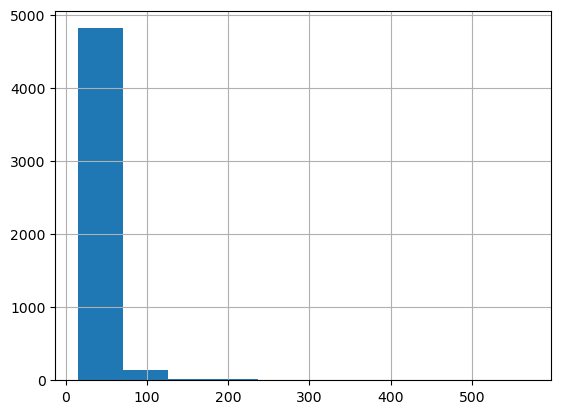

In [41]:
gapless_runs_df.gain.round().hist()

In [43]:
import matplotlib.pyplot as plt

(array([4.816e+03, 1.460e+02, 2.200e+01, 1.500e+01, 5.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 15.00411516,  70.45749928, 125.91088341, 181.36426753,
        236.81765166, 292.27103579, 347.72441991, 403.17780404,
        458.63118817, 514.08457229, 569.53795642]),
 <BarContainer object of 10 artists>)

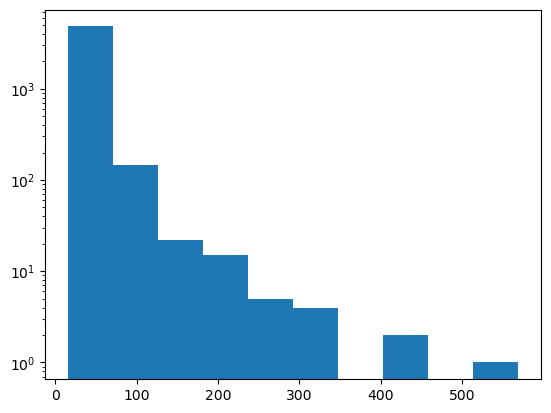

In [44]:
plt.hist(gapless_runs_df.gain, log=True) 

(array([4.237e+03, 4.960e+02, 1.430e+02, 6.400e+01, 2.300e+01, 1.600e+01,
        3.000e+00, 5.000e+00, 9.000e+00, 5.000e+00]),
 array([ 15.00411516,  37.49912135,  59.99412755,  82.48913375,
        104.98413995, 127.47914614, 149.97415234, 172.46915854,
        194.96416474, 217.45917094, 239.95417713]),
 <BarContainer object of 10 artists>)

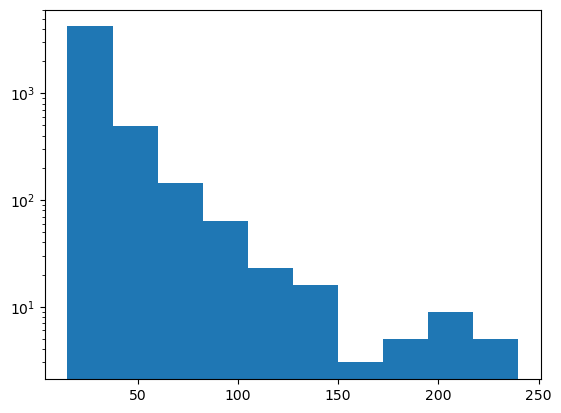

In [45]:
gain = gapless_runs_df.gain
plt.hist(gain[gain < 250], log=True) 

(array([2901., 1021.,  437.,  222.,  123.,   81.,   53.,   38.,   28.,
          30.]),
 array([15.00411516, 23.48826843, 31.9724217 , 40.45657497, 48.94072824,
        57.42488151, 65.90903478, 74.39318806, 82.87734133, 91.3614946 ,
        99.84564787]),
 <BarContainer object of 10 artists>)

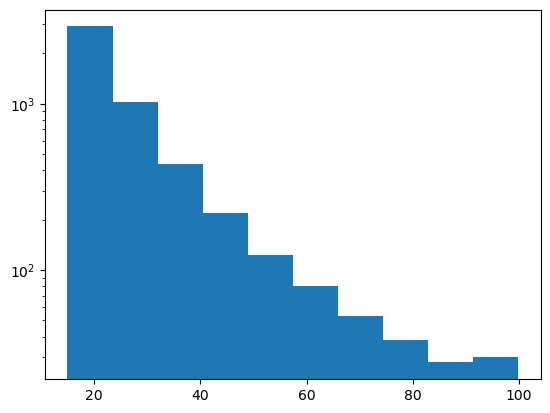

In [46]:
plt.hist(gain[gain < 100], log=True) 

(array([4.997e+03, 7.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00134200e+05, 7.18869029e+07, 1.43673672e+08, 2.15460440e+08,
        2.87247209e+08, 3.59033978e+08, 4.30820746e+08, 5.02607515e+08,
        5.74394284e+08, 6.46181052e+08, 7.17967821e+08]),
 <BarContainer object of 10 artists>)

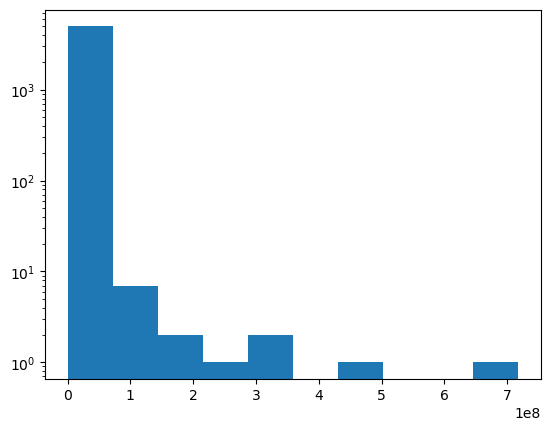

In [47]:
traded_value = gapless_runs_df.traded_value
plt.hist(traded_value, log=True) 

(array([636., 454., 390., 295., 229., 217., 179., 179., 136., 142.]),
 array([100134.2  , 189808.691, 279483.182, 369157.673, 458832.164,
        548506.655, 638181.146, 727855.637, 817530.128, 907204.619,
        996879.11 ]),
 <BarContainer object of 10 artists>)

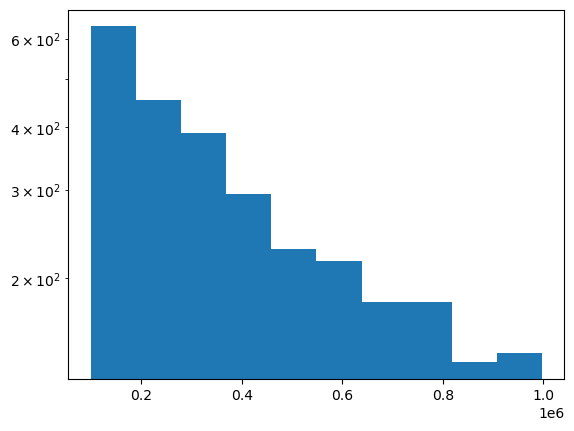

In [51]:
plt.hist(traded_value[traded_value < 1_000_000], log=True)

(array([1.936e+03, 1.330e+02, 3.500e+01, 2.100e+01, 1.000e+01, 3.000e+00,
        1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00]),
 array([ 1000630.71      , 10184479.60649999, 19368328.50299999,
        28552177.39949998, 37736026.29599997, 46919875.19249997,
        56103724.08899996, 65287572.98549996, 74471421.88199994,
        83655270.77849993, 92839119.67499992]),
 <BarContainer object of 10 artists>)

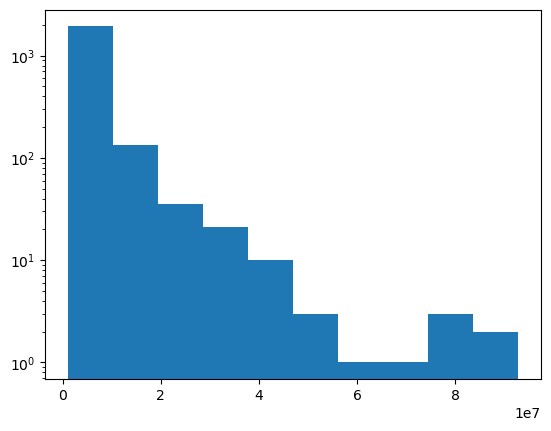

In [53]:
plt.hist(traded_value[(traded_value > 1_000_000) & (traded_value < 100_000_000)], log=True)

In [55]:
len(gapless_runs_df[(traded_value > 1_000_000)])

2154

(array([842., 606., 384., 247.,  38.,  20.,  13.,   2.,   1.,   1.]),
 array([ 3. ,  5.3,  7.6,  9.9, 12.2, 14.5, 16.8, 19.1, 21.4, 23.7, 26. ]),
 <BarContainer object of 10 artists>)

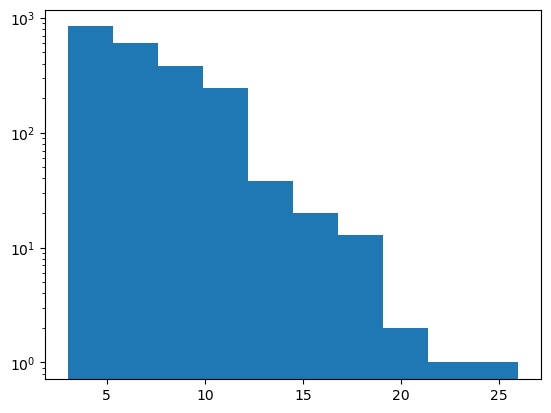

In [57]:
plt.hist(gapless_runs_df[(traded_value > 1_000_000)]["duration"], log=True)

In [65]:
million_5min = gapless_runs_df[(traded_value > 1_000_000) & (gapless_runs_df["duration"] > 5)]
len(million_5min), million_5min["gain"].sum() / len(million_5min), million_5min["traded_value"].sum() / len(million_5min)

(1312, 32.50453666066949, 7219312.977070692)

In [66]:
million_5min_g25 = gapless_runs_df[(traded_value > 1_000_000) & (gapless_runs_df["duration"] > 5) & (gapless_runs_df["gain"] > 25)]
len(million_5min_g25), million_5min_g25["gain"].sum() / len(million_5min_g25), million_5min_g25["traded_value"].sum() / len(million_5min_g25)

(599, 48.319087300711665, 7103055.165176961)

In [67]:
g25_5min = gapless_runs_df[(gapless_runs_df["duration"] > 5) & (gapless_runs_df["gain"] > 25)]
len(g25_5min), g25_5min["gain"].sum() / len(g25_5min), g25_5min["traded_value"].sum() / len(g25_5min)

(1100, 47.22031236224534, 4075607.2961197263)

In [69]:
g25_5min["day_of_week"] = g25_5min.index.get_level_values('start_dt').day_of_week
g25_5min

/tmp/ipykernel_1471299/2416705491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g25_5min["day_of_week"] = g25_5min.index.get_level_values('start_dt').day_of_week


,,gain,duration,volume,traded_value,end_dt,previous_price,start_price,end_price,next_price,prices,day_of_week
ticker,start_dt,,,,,,,,,,,
APM,2020-09-29 10:15:00+00:00,441.912069,9,309132.0,3.090555e+06,2020-09-29 10:24:00+00:00,5.113903,4.711132,25.530192,15.394177,"[4.711, 4.981, 5.879, 6.297, 6.844, 8.637, 10....",1
BCAN,2022-09-19 09:26:00+00:00,406.123521,15,13872.0,1.746845e+05,2022-09-19 09:41:00+00:00,5.150000,5.148932,26.059957,24.148420,"[5.149, 5.25, 5.37, 5.575, 5.779, 5.982, 6.226...",0
ATAK,2023-12-15 09:37:00+00:00,339.518457,7,2152.0,1.547558e+05,2023-12-15 09:44:00+00:00,23.466667,20.642500,90.727597,89.756874,"[20.643, 21.258, 23.0, 23.056, 37.912, 59.482,...",4
IONM,2022-08-05 08:20:00+00:00,313.294907,8,361887.0,2.029565e+06,2022-08-05 08:28:00+00:00,2.343343,2.340233,9.672066,7.921674,"[2.34, 2.363, 2.373, 2.777, 3.677, 4.959, 5.63...",4
SYTAW,2021-10-20 12:22:00+00:00,301.105211,10,166904.0,5.913084e+05,2021-10-20 12:32:00+00:00,1.548686,1.542499,6.187042,4.611293,"[1.542, 1.626, 1.654, 1.763, 1.899, 2.055, 2.1...",2
...,...,...,...,...,...,...,...,...,...,...,...,...
SLE,2023-09-11 13:04:00+00:00,25.020412,6,180019.0,8.884100e+05,2023-09-11 13:10:00+00:00,4.313882,4.297892,5.373242,5.295870,"[4.298, 4.304, 4.436, 4.732, 5.068, 5.347, 5.373]",0
BSFC,2022-01-21 12:58:00+00:00,25.016084,7,562755.0,3.330332e+06,2022-01-21 13:05:00+00:00,5.079104,5.011979,6.265780,6.129003,"[5.012, 5.029, 5.13, 5.438, 5.653, 6.081, 6.13...",4
AGRX,2022-06-27 10:20:00+00:00,25.013533,7,320022.0,5.773210e+05,2022-06-27 10:27:00+00:00,1.531348,1.526883,1.908810,1.896544,"[1.527, 1.547, 1.557, 1.597, 1.652, 1.655, 1.7...",0


In [71]:
g25_5min.day_of_week.value_counts()

day_of_week
3    226
4    223
1    220
0    219
2    212
Name: count, dtype: int64

In [54]:
gapless_runs_df[(traded_value > 1_000_000) & (traded_value < 100_000_000)]

,,gain,duration,volume,traded_value,end_dt,previous_price,start_price,end_price,next_price,prices
ticker,start_dt,,,,,,,,,,
APM,2020-09-29 10:15:00+00:00,441.912069,9,309132.0,3090554.600,2020-09-29 10:24:00+00:00,5.113903,4.711132,25.530192,15.394177,"[4.711, 4.981, 5.879, 6.297, 6.844, 8.637, 10...."
IONM,2022-08-05 08:20:00+00:00,313.294907,8,361887.0,2029564.590,2022-08-05 08:28:00+00:00,2.343343,2.340233,9.672066,7.921674,"[2.34, 2.363, 2.373, 2.777, 3.677, 4.959, 5.63..."
OPGN,2023-10-12 08:10:00+00:00,295.851195,10,1726939.0,4498084.245,2023-10-12 08:20:00+00:00,1.058414,1.030604,4.079660,2.783647,"[1.031, 1.099, 1.145, 1.237, 1.477, 1.963, 2.1..."
BSFC,2022-01-21 10:21:00+00:00,271.222186,13,519919.0,5675578.610,2022-01-21 10:34:00+00:00,6.250109,6.044325,22.437876,20.017011,"[6.044, 6.165, 6.551, 6.872, 7.126, 7.214, 7.8..."
IMRN,2020-06-09 13:13:00+00:00,239.954177,6,453176.0,4064781.830,2020-06-09 13:19:00+00:00,3.214194,3.163183,10.753374,10.559613,"[3.163, 3.18, 3.423, 3.834, 6.781, 9.616, 10.753]"
...,...,...,...,...,...,...,...,...,...,...,...
MARPS,2022-03-08 14:11:00+00:00,15.015400,6,95081.0,2483156.390,2022-03-08 14:17:00+00:00,23.904131,23.552318,27.088793,26.789389,"[23.552, 24.001, 25.111, 25.582, 25.734, 26.83..."
OCG,2020-12-17 13:02:00+00:00,15.008249,5,142891.0,2848346.080,2020-12-17 13:07:00+00:00,17.956788,17.913157,20.601608,20.105194,"[17.913, 18.044, 18.699, 19.557, 20.241, 20.602]"
SCKT,2020-10-23 11:04:00+00:00,15.007007,5,1221599.0,3832294.720,2020-10-23 11:09:00+00:00,2.855088,2.851726,3.279684,3.214353,"[2.852, 3.034, 3.133, 3.187, 3.2, 3.28]"


In [50]:
gapless_runs_df.sort_values("traded_value", ascending=False)

gain  duration      volume  traded_value                    end_dt  previous_price  start_price   end_price  next_price                                             prices
ticker start_dt                                                                                                                                                                                                  
GME    2021-01-27 14:13:00+00:00  51.073813        10   2232906.0  7.179678e+08 2021-01-27 14:23:00+00:00      250.039450   248.452134  375.346112  344.722719  [248.452, 249.178, 250.1, 256.686, 262.628, 27...
AMC    2021-01-27 14:06:00+00:00  24.106029         6  22292817.0  4.968030e+08 2021-01-27 14:12:00+00:00       19.685132    19.643959   24.379337   22.690405  [19.644, 19.98, 20.705, 21.438, 22.718, 24.066...
AAL    2021-01-28 12:55:00+00:00  18.235133         6  11577202.0  3.286017e+08 2021-01-28 13:01:00+00:00       25.964431    25.132324   29.715236   28.801101  [25.132, 25.887, 26.814, 28.378, 29.544, 29.58...
       2021-01-28 12:36:00+00:00  30.281705        18  13581343.0  3.174438e+08 2021-01-28 12:54:00+00:00       20.341572    19.929453   25.964431   25.132324  [19.929, 20.001, 20.114, 20.384, 20.676, 21.10...
MRNA   2021-01-29 13:09:00+00:00  18.676652         9   1215277.0  2.355731e+08 2021-01-29 13:18:00+00:00      176.601300   176.446935  209.401316  203.676911  [176.447, 177.458, 179.604, 181.574, 184.506, ...
...                                     ...       ...         ...           ...                       ...             ...          ...         ...         ...                                                ...
FRAN   2019-07-17 11:27:00+00:00  22.770984         4     22634.0  1.006876e+05 2019-07-17 11:31:00+00:00        4.076622     3.812132    4.680192    4.442199                 [3.812, 3.991, 4.198, 4.405, 4.68]
BIMI   2022-05-24 08:38:00+00:00  58.632950         4     91518.0  1.003828e+05 2022-05-24 08:42:00+00:00        0.808415     0.781424    1.239595    1.218780                 [0.781, 0.858, 1.077, 1.162, 1.24]
CMND   2023-03-13 11:16:00+00:00  16.398022         4     21323.0  1.001703e+05 2023-03-13 11:20:00+00:00        4.174681     4.168707    4.852293    4.706649                [4.169, 4.215, 4.598, 4.778, 4.852]
CHNR   2020-06-15 10:00:00+00:00  42.811989         7     41298.0  1.001396e+05 2020-06-15 10:07:00+00:00        1.862308     1.855679    2.650133    2.597871  [1.856, 1.888, 1.987, 2.061, 2.155, 2.21, 2.43...
IPWR   2019-10-16 12:53:00+00:00  15.468119         7     27372.0  1.001342e+05 2019-10-16 13:00:00+00:00        3.322208     3.296667    3.806599    3.691666  [3.297, 3.425, 3.441, 3.546, 3.653, 3.718, 3.7...

[5011 rows x 10 columns]

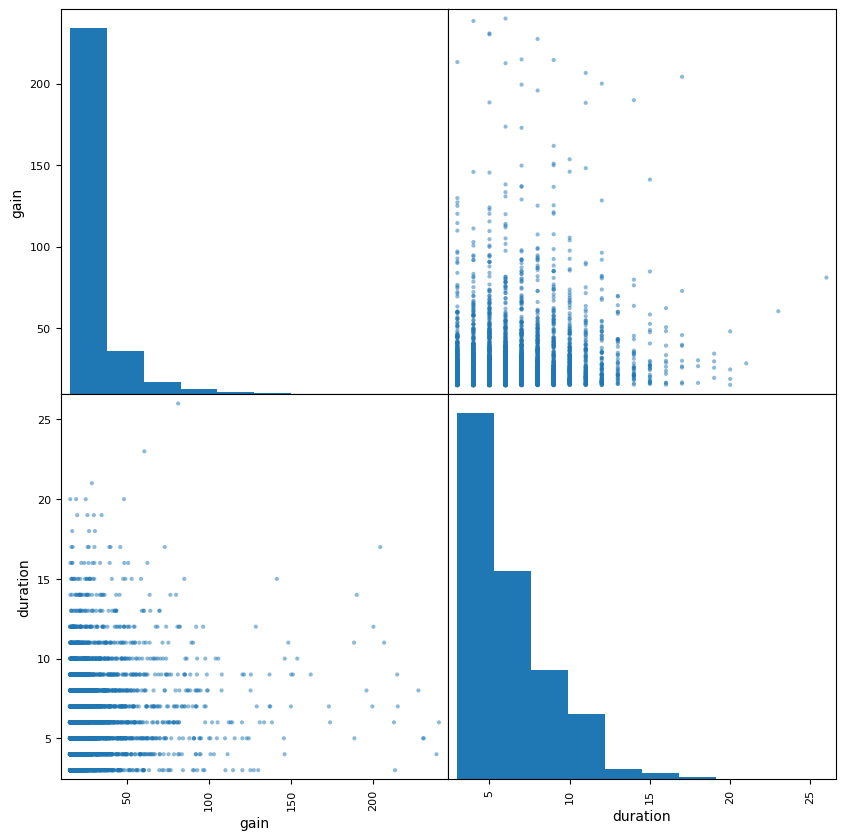

In [79]:
pd.plotting.scatter_matrix(gapless_runs_df[gapless_runs_df.gain < 250][["gain", "duration"]], diagonal='hist', figsize=(10, 10))
plt.show()

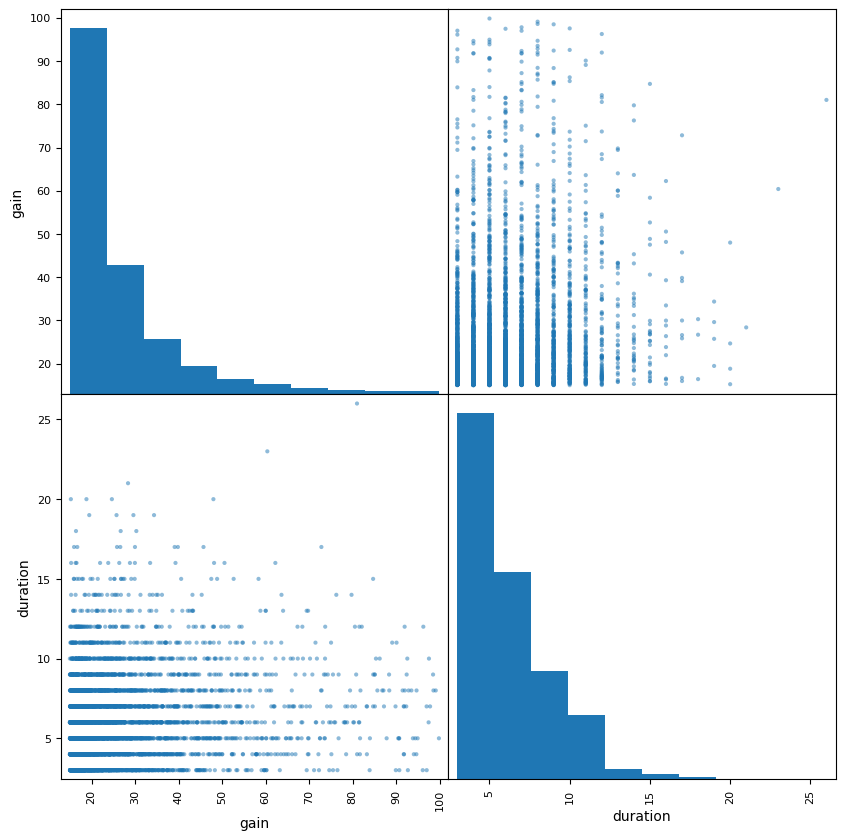

In [85]:
pd.plotting.scatter_matrix(gapless_runs_df[gapless_runs_df.gain < 100][["gain", "duration"]], diagonal='hist', figsize=(10, 10))
plt.show()

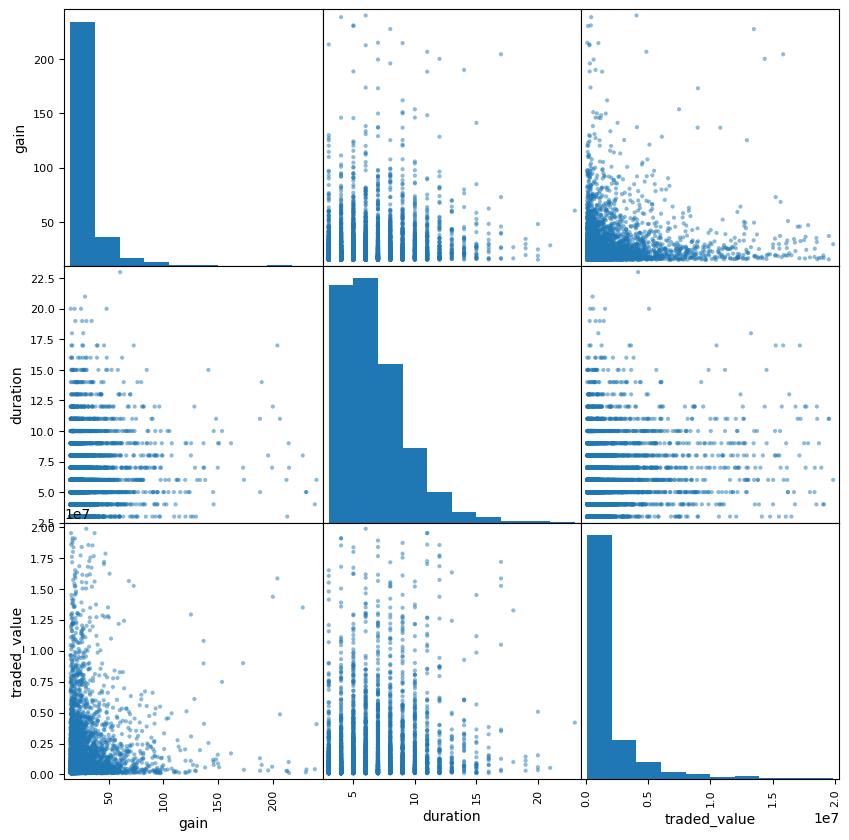

In [87]:
pd.plotting.scatter_matrix(gapless_runs_df[(gapless_runs_df.gain < 250) & (gapless_runs_df.traded_value < 20_000_000)][["gain", "duration", "traded_value"]], diagonal='hist', figsize=(10, 10))
plt.show()

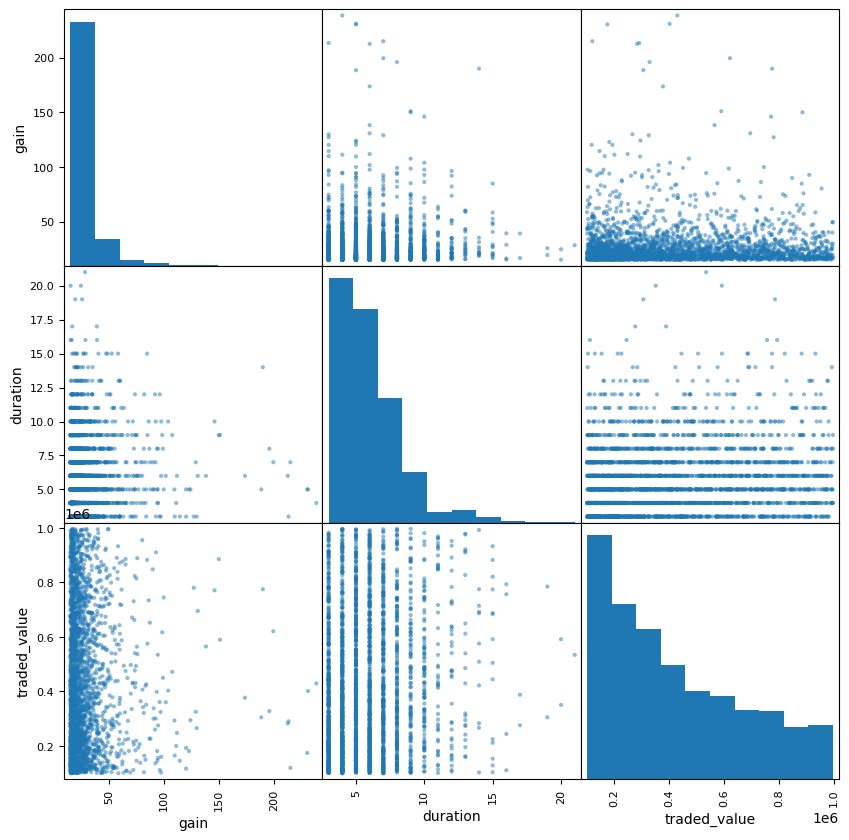

In [88]:
pd.plotting.scatter_matrix(gapless_runs_df[(gapless_runs_df.gain < 250) & (gapless_runs_df.traded_value < 1_000_000)][["gain", "duration", "traded_value"]], diagonal='hist', figsize=(10, 10))
plt.show()

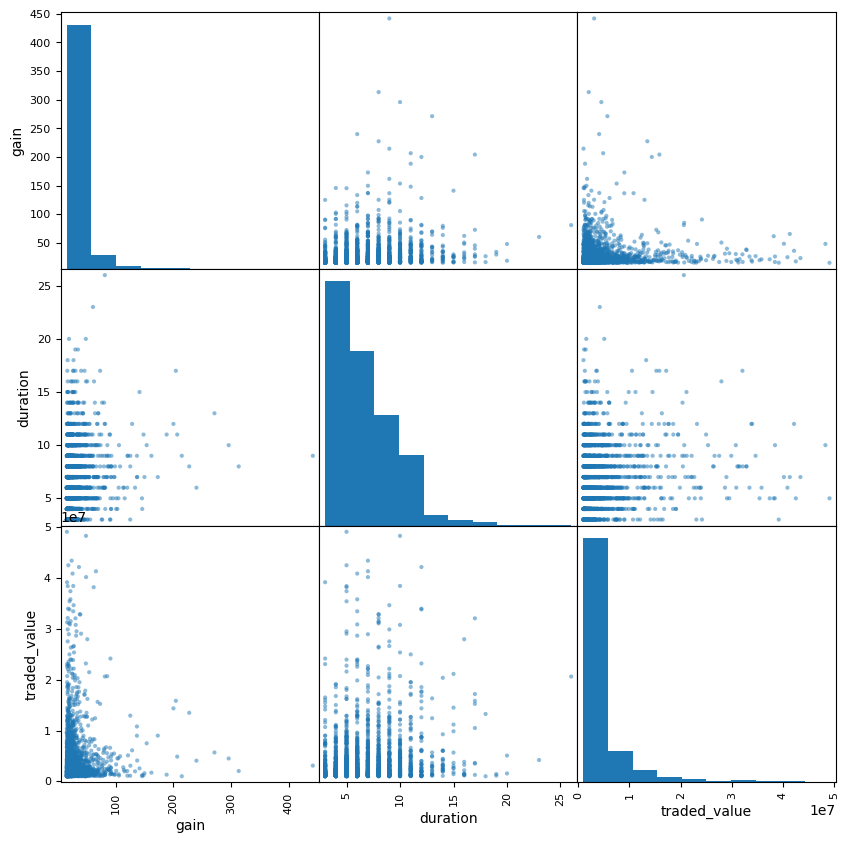

In [89]:
pd.plotting.scatter_matrix(gapless_runs_df[(gapless_runs_df.traded_value > 1_000_000)& (gapless_runs_df.traded_value < 50_000_000)][["gain", "duration", "traded_value"]], diagonal='hist', figsize=(10, 10))
plt.show()

len(df)=684


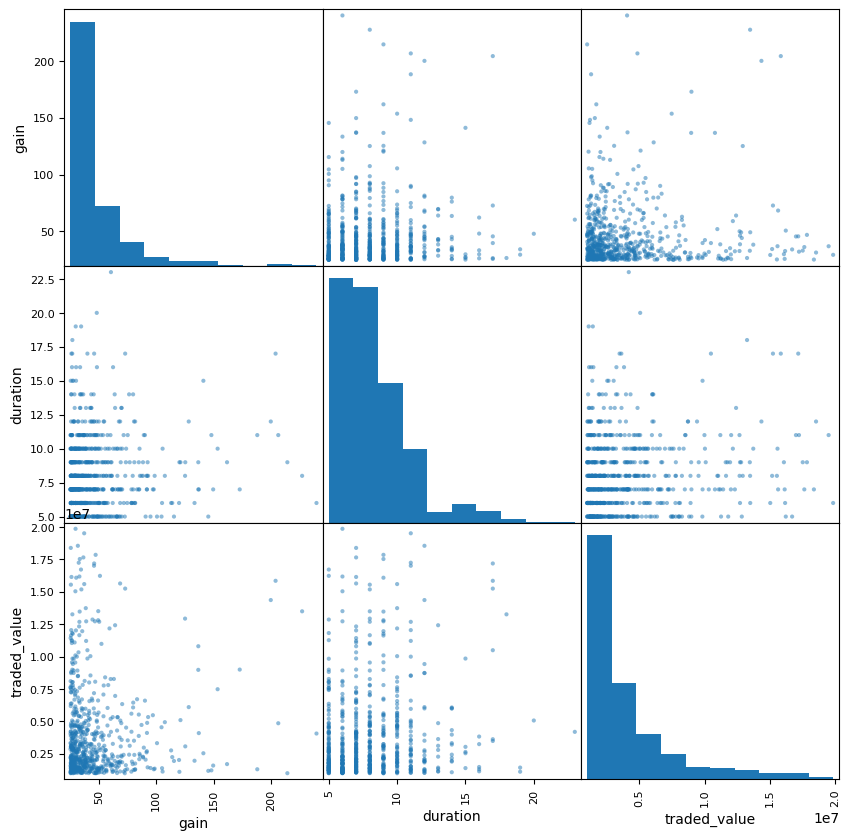

In [97]:
df = gapless_runs_df[(gapless_runs_df.duration > 4) & (gapless_runs_df.gain > 25) & (gapless_runs_df.gain < 250) & (gapless_runs_df.traded_value > 1_000_000) & (gapless_runs_df.traded_value < 20_000_000)]
print(f"{len(df)=}")
pd.plotting.scatter_matrix(df[["gain", "duration", "traded_value"]], diagonal='hist', figsize=(10, 10))
plt.show()

In [72]:
import seaborn as sns

In [75]:
cov_matrix = gapless_runs_df[["gain", "duration"]].cov()
cov_matrix

,gain,duration
gain,631.46757,9.184390
duration,9.18439,7.209492


Text(0.5, 1.0, 'Correlation Matrix')

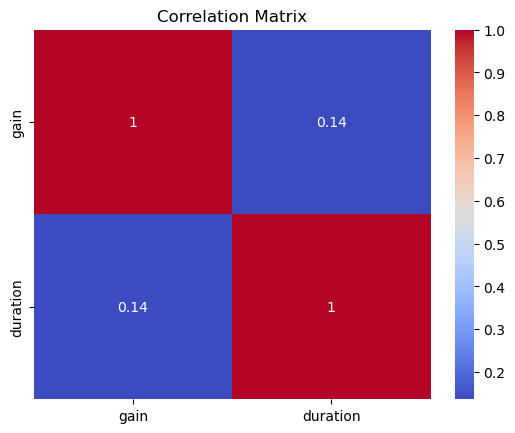

In [73]:


# Plot the correlation matrix using Seaborn
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")

In [74]:
corr_matrix

,gain,duration
gain,1.00000,0.13612
duration,0.13612,1.00000
